In [1]:
!pip install pyyaml
!pip install dndice
!pip install python-i18n
!pip install gymnasium
!pip install inflect
!pip install collections-extended
!pip install openai
!pip install -e ..
!pip install ipywidgets
!pip install iprogress


Obtaining file:///home/jedld/workspace/natural_20.py
  Preparing metadata (setup.py) ... done
  Attempting uninstall: natural20.py
    Found existing installation: natural20.py 0.1
    Uninstalling natural20.py-0.1:
      Successfully uninstalled natural20.py-0.1
  Running setup.py develop for natural20.py


In [1]:
from gymnasium import make
from model import QNetwork
from natural20.gym.dndenv import dndenv
import torch
import tqdm as tqdm
import tqdm.notebook as tqdm
import random
import torch.optim as optim
import torch.nn as nn
import gc
import numpy as np
import sys
import collections
from natural20.session import Session
from natural20.event_manager import EventManager
from natural20.gym.dqn.replay_buffer import ReplayBuffer
import os
from llm_interface import GPT4Interfacer

In [2]:
if torch.backends.mps.is_available():
  device = torch.device("mps")
else:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

cuda


In [3]:
env_config = "map_with_obstacles"

In [4]:
session = Session(env_config, event_manager=EventManager())

Show info about the environment and a render of the tabletop map

In [5]:
env = make("dndenv-v0", root_path="map_with_obstacles", show_logs=True,
           custom_session=session,
           damaged_based_reward=True,
           render_mode="ansi")
env.reset()
print(env.render())
print(env.observation_space)
print(env.action_space.sample)

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
str: 11 dex: 20 con: 16 int: 11 wis: 12 cha: 17 
name: gomerin
level: 2
character class: {'rogue': 2}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
str: 11 dex: 20 con: 16 int: 11 wis: 12 cha: 17 
name: rumblebelly
level: 2
character class: {'rogue': 2}
hp: 18
max hp: 18
ac: 16
speed: 25



____________
____________
____________
____________
____________
......._____
......P_____
   #E.._____
  ~~~.._____
~~~...._____
~~....._____
____________
Dict('ability_info': Box(0, 1, (8,), int64), 'conditions': Box(0, 1, (8,), int64), 'enemy_ac': Box(0.0, 1.0, (1,), float64), 'enemy_conditions': Box(0, 1, (8,), int64), 'enemy_reactions': Box(0, 1, (1,), int64), 'enemy_type': Box(0, 1, (1,), int64), 'health_enemy': Box(0.0, 1.0, (1,), float64), 'health_pct': Box(0.0, 1.0, (1,), float64), 'is_reaction': Box(0, 1, (1,), int64), 'map': Box(-1, 255, (12, 12, 5), int64), 'move

/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:318: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


DQN Parameters

In [6]:
TRAJECTORY_POLICY = "e-greedy"
NUM_UPDATES = 2 # number of training steps to update the Q-network
TEMP_DECAY = 0.999
BUFFER_CAPACITY = 3000
FRAMES_TO_STORE = 2
MAX_STEPS = 1000
BATCH_SIZE = 64
TARGET_UPDATE_FREQ = 1 # how often to update the target network
T_HORIZON = 1024
EPSILON_START = 1.0
EPSILON_FINAL = 0.01
EPSILON_DECAY_FRAMES = 10**3
EVAL_STEPS = 25

In [7]:
model = QNetwork(device=device)
model.to(device)
state, info = env.reset()
moves = info["available_moves"]
model.eval()
print(model(state, moves[0]))

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
str: 11 dex: 20 con: 16 int: 11 wis: 12 cha: 17 
name: gomerin
level: 2
character class: {'rogue': 2}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
str: 11 dex: 20 con: 16 int: 11 wis: 12 cha: 17 
name: rumblebelly
level: 2
character class: {'rogue': 2}
hp: 18
max hp: 18
ac: 16
speed: 25



tensor([[-0.0973]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [8]:
def act_with_policy(state, info, model, policy='e-greedy', temperature=5.0, epsilon=0.1):
    available_moves = info["available_moves"]
    with torch.no_grad():
        if policy == 'boltzmann':
            values = torch.stack([model(state, move).squeeze() for move in available_moves])
            if len(values) > 1:
                if temperature != 0:
                    values = values / temperature
                else:
                    raise ValueError("Temperature is zero, which can lead to division by zero.")

                # Stabilizing the exponential calculation
                values = values - torch.max(values)  # Subtract the max value for numerical stability
                values = torch.exp(values)
                sum_values = torch.sum(values)

                if sum_values > 0:
                    values = values / sum_values
                    chosen_index = torch.multinomial(values, 1).item()
                else:
                    print("Sum of exponentiated values is zero. Adjust the model or input.")
                    chosen_index = torch.randint(len(available_moves), (1,)).item()
            else:
                chosen_index = 0
        elif policy == 'e-greedy':
            if random.random() < epsilon:
                # place available moves in buckets according to their type
                # this is so that movements are not chosen more often than other types of moves
                move_types = collections.defaultdict(list)
                for orig_index, move in enumerate(available_moves):
                    move_types[move[0]].append(orig_index)
                chosen_move_type = random.choice(list(move_types.keys()))
                chosen_index = random.choice(move_types[chosen_move_type])
            else:
                values = torch.stack([model(state, move) for move in available_moves])
                chosen_index = torch.argmax(values).item()
        elif policy == 'greedy':
                values = torch.stack([model(state, move) for move in available_moves])
                chosen_index = torch.argmax(values).item()
        else:
            raise ValueError(f"Unknown policy: {policy}")
    
    return available_moves[chosen_index]

def generate_trajectory(env, model, policy='e-greedy', temperature=5.0, epsilon=0.1, horizon=2048, quick_exit=False):

    done = False
    truncated = False
    states = []
    actions = []
    rewards = []
    dones = []
    truncateds = []
    infos = []
    truncated = False


    def reaction_callback(state, reward, done, truncated, info):
        action = act_with_policy(state, info, model, policy, temperature, epsilon)
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        truncateds.append(truncated)
        infos.append(info)

        return action

    state, info = env.reset(reaction_callback=reaction_callback)

    for _ in range(horizon):
        # instead of sampling  (e.g. env.action_space.sample()) we can ask help from the enivronment to obtain valid moves
        # as there are sparse valid moves in the environment
        action = act_with_policy(state, info, model, policy, temperature, epsilon)
        next_state, reward, done, truncated, next_info = env.step(action)

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        truncateds.append(truncated)
        infos.append(info)

        if done:
            break    
        if truncated:
            truncated = True
            break
        state = next_state
        info = next_info
        
    states.append(next_state)
    infos.append(next_info)
    actions.append((-1, (0,0), (0,0), 0, 0))
    return states, actions, rewards, dones, truncateds, infos

In [9]:
trajectory = generate_trajectory(env, model, epsilon=1.0)
print(trajectory)

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
str: 11 dex: 20 con: 16 int: 11 wis: 12 cha: 17 
name: gomerin
level: 2
character class: {'rogue': 2}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
str: 11 dex: 20 con: 16 int: 11 wis: 12 cha: 17 
name: rumblebelly
level: 2
character class: {'rogue': 2}
hp: 18
max hp: 18
ac: 16
speed: 25



no move for rumblebelly
==== current turn gomerin 12/18 AC 16===
==== end turn ===
gomerin 12/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 12/18 AC 16===
Result: False


/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


==== end turn ===
gomerin 12/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 12/18 AC 16===
Result: False
==== end turn ===
gomerin 12/18
rumblebelly 9/18
==== current turn rumblebelly 9/18 AC 16===
no move for rumblebelly
==== current turn gomerin 12/18 AC 16===
Result: False
==== end turn ===
gomerin 12/18
rumblebelly 9/18
==== current turn rumblebelly 9/18 AC 16===
no move for rumblebelly
==== current turn gomerin 12/18 AC 16===
Result: False
==== end turn ===
gomerin 12/18
rumblebelly 9/18
==== current turn rumblebelly 9/18 AC 16===
no move for rumblebelly
==== current turn gomerin 11/18 AC 16===
Result: False
==== end turn ===
gomerin 11/18
rumblebelly 3/18
==== current turn rumblebelly 3/18 AC 16===
no move for rumblebelly
==== current turn gomerin 11/18 AC 16===
Result: False
==== end turn ===
gomerin 11/18
rumblebelly 3/18
==== current turn rumblebelly 3/18 AC 16===
no move for rumblebelly
==== current turn gom

In [10]:
EPISODES = 10
total_rewards = 0
for i in tqdm.tqdm(range(EPISODES)):
    states, actions, rewards, dones, truncateds, infos = generate_trajectory(env, model, epsilon=1.0)
    total_rewards += sum(rewards)

avg_reward = total_rewards/EPISODES
print(f"Average reward: {avg_reward} Total Reward: {total_rewards}")

  0%|          | 0/10 [00:00<?, ?it/s]

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
str: 11 dex: 20 con: 16 int: 11 wis: 12 cha: 17 
name: gomerin
level: 2
character class: {'rogue': 2}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
str: 11 dex: 20 con: 16 int: 11 wis: 12 cha: 17 
name: rumblebelly
level: 2
character class: {'rogue': 2}
hp: 18
max hp: 18
ac: 16
speed: 25



no move for rumblebelly
==== current turn gomerin 18/18 AC 16===
==== end turn ===
gomerin 18/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 11/18 AC 16===
Result: False
==== end turn ===
gomerin 11/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 3/18 AC 16===
Result: False
==== end turn ===
gomerin 3/18
rumblebelly 18/18
==== current turn rumblebelly 18/18 AC 16===
no move for rumblebelly
==== current turn gomerin 3/18 AC 16===
Result: Fal

In [11]:
# generate a batch of trajectories and store them in the replay buffer
def generate_batch_trajectories(env, model, n_rollout, replay_buffer: ReplayBuffer, temperature=5.0, epsilon=0.1, horizon=30, policy='e-greedy'):
    # print(f"generating {n_rollout} rollouts")
    for _ in range(n_rollout):
        state, action, reward, done, truncated, info = generate_trajectory(env, model, temperature=temperature,
                                                                           epsilon=epsilon,
                                                                           horizon=horizon,policy=policy)
        replay_buffer.push(state, action, reward, info, done)

In [12]:
def train(env, gamma, learning_rate, max_steps=MAX_STEPS, use_td_target=True,
          trajectory_policy='e-greedy',
          label="dnd_egreedy",
          eval_env=None,
          n_rollout=8,
          seed=1337):
  print(f"training with gamma {gamma} and learning rate {learning_rate}")
  env.seed(seed)

  replay_buffer = ReplayBuffer(BUFFER_CAPACITY, device)
  # load model checkpoint if available
  model = QNetwork(device).to(device)
  target_model = QNetwork(device).to(device)

  # intialize target network with the same weights as the model
  target_model.load_state_dict(model.state_dict())

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  best_avg = -10
  best_step = 0
  temperature = 5.0
  reward_per_episode = []
  epsilon = EPSILON_START

  for step in tqdm.tqdm(range(max_steps)):
    generate_batch_trajectories(env, model, n_rollout, replay_buffer, temperature=temperature,
                                epsilon=epsilon, policy=trajectory_policy, horizon=T_HORIZON)

    states, actions, rewards, infos, is_terminals = replay_buffer.sample(BATCH_SIZE)
    rewards_collected = 0
    for _ in range(NUM_UPDATES):
      rewards_collected = 0
      total_loss = 0.0

      for i in range(len(states)):
        s = states[i]
        a = actions[i]
        env_info = infos[i]
        r = torch.tensor(rewards[i]).to(device).unsqueeze(1)
        is_terminal = torch.tensor(is_terminals[i]).float().to(device).unsqueeze(1)

        if use_td_target:
          with torch.no_grad():
            s_next = s[1:]
            a_next = a[1:]
            q_targets = target_model.forward(s_next, a_next, pre_converted=True, pre_converted_action=True).detach()
        else: # Q-learning target == "slow"
          with torch.no_grad():
            s_next = s[1:]
            s_info = env_info[1:]
            q_targets = torch.zeros(len(s_next)).to(device)

            for index in range(len(s_info)):
              info = s_info[index]
              state = s_next[index]

              if len(state) == 0:
                q_targets[index] = 0
                continue

              total_available_moves = len(info["available_moves"])
              states_t = [state] * total_available_moves
              avail_actions = info["available_moves"]
              assert len(states_t) > 0, "No available states"
              assert len(avail_actions) > 0, "No available moves"

              q_values = target_model.forward(states_t, avail_actions, pre_converted=True).detach().squeeze(1)
              if len(q_values) == 0:
                q_targets[index] = 0
              else:
                q_targets[index] = torch.max(q_values).item()

            q_targets = q_targets.unsqueeze(1)
            assert q_targets.shape == r.shape, f"q_targets shape {q_targets.shape} != r shape {r.shape}"

        targets = r + gamma * q_targets * (1 - is_terminal)

        s_input = s[0:-1]
        a_input = a[0:-1]
        output = model.forward(s_input, a_input, pre_converted=True, pre_converted_action=True)
        q_sa = output

        value_loss = nn.MSELoss()(q_sa, targets)
        optimizer.zero_grad()
        value_loss.backward()
        total_loss += value_loss.item()
        rewards_collected += r.sum().item()
        optimizer.step()

    # save model checkpoint

    # evaluate model performance
    if step % 10 == 0:
      if eval_env is None:
        eval_env = env

      eval_rewards = []
      for _ in range(EVAL_STEPS):
        _, _, rewards, _, _, _ = generate_trajectory(eval_env, model, policy='greedy')
        total_reward = sum(rewards)
        eval_rewards.append(total_reward)

      avg_rewards = np.mean(eval_rewards)
      std_rewards = np.std(eval_rewards)
      # print(f"eval rewards: {avg_rewards}")
      reward_per_episode.append(avg_rewards)

      # print(f"total reward: {total_reward}")
      if trajectory_policy == "e-greedy":
        print(f"{step}: avg rewards {avg_rewards} std: {std_rewards} best avg {best_avg}@{best_step} epsilon {epsilon}")
      elif trajectory_policy == "boltzmann":
        print(f"{step}: avg rewards {avg_rewards} std: {std_rewards} best avg {best_avg}@{best_step} temperature {temperature}")
      else:
        print(f"{step}: avg rewards {avg_rewards} std: {std_rewards} best avg {best_avg}@{best_step}")

      replay_buffer.print_stats()

      if avg_rewards > best_avg:
        print(f"best: {avg_rewards}")
        best_avg = avg_rewards
        best_step = step
        torch.save(model.state_dict(), f"model_best_{label}@{step}.pt")
        torch.save(model.state_dict(), f"model_best_{label}.pt")

      # torch.save(model.state_dict(), f"model_{label}_{gamma}_{learning_rate}.pt")


    # if step % 100 == 0:
    #   torch.save(model.state_dict(), f"model_{label}_{gamma}_{learning_rate}_{step}.pt")


    gc.collect()
    
    # decay temp
    temperature = np.max([0.1, temperature * TEMP_DECAY])

    # decay epsilon
    epsilon = EPSILON_FINAL + (EPSILON_START - EPSILON_FINAL) * np.exp(-1.0 * step / EPSILON_DECAY_FRAMES)

    if step % TARGET_UPDATE_FREQ == 0:
      # calculate the avg change weights of the model with the target model
      total_change = 0
      for p, p_target in zip(model.parameters(), target_model.parameters()):
        total_change += torch.abs(p - p_target).sum().item()
      # print(f"total change: {total_change}")

      target_model.load_state_dict(model.state_dict())

  env.close()
  return reward_per_episode


Specify the location of the game configuration

In [13]:
game_setup_path = "map_with_obstacles"

Create the env setup. Note that we use damaged based rewards to give a denser reward signalling.

In [14]:
def make_env(root_path, render_mode="ansi", show_logs=False, custom_agent=None):
    return make("dndenv-v0", root_path=root_path, show_logs=show_logs,
                render_mode=render_mode,
                damage_based_reward=True,
                custom_agent=custom_agent,
                profiles=lambda: random.choice(['high_elf_fighter']),
                enemies=lambda: random.choice(['high_elf_fighter']),
                map_file=lambda: random.choice(['maps/simple_map',\
                                                'maps/complex_map', \
                                                'maps/game_map', \
                                                'maps/walled_map'])
                )

In [15]:
env = make_env(game_setup_path)

In [17]:
seed = 1337
# Create a grid of learning rates and gammas
learning_rates = [0.0001]
gammas = [0.99]

results = {}
for lr in learning_rates:
  results[lr] = {}
  for gamma in gammas:
    seed = seed + 1
    reward_per_episode = train(env, gamma, lr, max_steps=MAX_STEPS, seed=seed, use_td_target=True)
    results[lr][gamma] = reward_per_episode


training with gamma 0.99 and learning rate 0.0001


/home/jedld/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/jedld/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0: avg rewards -0.9999999999999997 std: 8.079466429027214 best avg -10@0 epsilon 1.0
Buffer size: 8
Memory usage: 156544 bytes
best: -0.9999999999999997
10: avg rewards -9.166666666666666 std: 2.70801280154532 best avg -0.9999999999999997@0 epsilon 0.9911299749851548
Buffer size: 88
Memory usage: 1626688 bytes
20: avg rewards -9.899999999999999 std: 0.2708012801545322 best avg -0.9999999999999997@0 epsilon 0.9813675686203779
Buffer size: 168
Memory usage: 3243328 bytes
30: avg rewards -4.383333333333333 std: 6.162295748249096 best avg -0.9999999999999997@0 epsilon 0.9717022998219388
Buffer size: 248
Memory usage: 4724864 bytes
40: avg rewards -6.9 std: 5.262656701282685 best avg -0.9999999999999997@0 epsilon 0.962133202054903
Buffer size: 328
Memory usage: 6070272 bytes
50: avg rewards -5.416666666666668 std: 5.439056290693573 best avg -0.9999999999999997@0 epsilon 0.9526593184015199
Buffer size: 408
Memory usage: 7556544 bytes
60: avg rewards -5.15 std: 6.2158846693147565 best avg -0.

Summarize rewards per episode

In [18]:
for item in results:
  for gamma in results[item]:
    print(f"lr: {item} gamma: {gamma} rewards: {results[item][gamma]}")

lr: 0.0001 gamma: 0.99 rewards: [-0.9999999999999997, -9.166666666666666, -9.899999999999999, -4.383333333333333, -6.9, -5.416666666666668, -5.15, -6.0166666666666675, -1.7333333333333334, -1.35, -2.1, 1.0666666666666664, -0.11666666666666657, 1.7833333333333332, -1.3, -2.1166666666666667, -0.18333333333333343, 1.883333333333333, 1.0833333333333333, 2.716666666666667, 5.566666666666667, 1.8166666666666662, 6.3, 1.5666666666666667, 1.7333333333333332, 4.2, 1.9333333333333333, 5.516666666666667, 1.8166666666666669, 3.8, 2.4333333333333336, 0.9666666666666667, 4.083333333333333, 3.566666666666667, 4.416666666666667, 5.816666666666666, 2.8, 3.533333333333333, 0.7333333333333334, 2.666666666666666, 2.6, 7.099999999999999, 5.883333333333334, 5.166666666666666, 4.916666666666666, 3.483333333333333, 3.45, 5.383333333333333, 5.266666666666667, 7.516666666666667, 4.816666666666666, 4.683333333333333, 4.833333333333333, 7.116666666666667, 6.75, 5.566666666666667, 6.583333333333332, 7.55, 7.233333

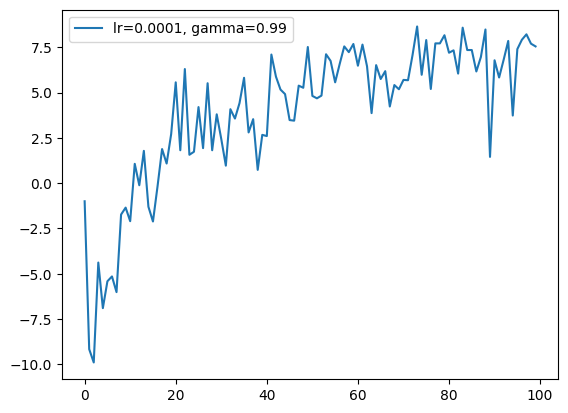

In [19]:
# plot the results
import matplotlib.pyplot as plt

for lr in learning_rates:
    for gamma in gammas:
        plt.plot(results[lr][gamma], label=f"lr={lr}, gamma={gamma}")
plt.legend()
plt.show()


Setup a mixed LLM vs Rules based AI adversary and compare performance

LLM related config, like which LLM to use

In [20]:
USE_OPENAI=False

In [21]:
if not USE_OPENAI:
    URL = os.getenv("OPENAI_BASE_URL", "http://localhost:8000/v1")

    if not URL:
        raise ValueError("Please set the OPENAI_BASE_URL environment variable")
    prompt = GPT4Interfacer(debug=False, tools=False, base_url=URL, api_key="token1234", variant="NousResearch/Meta-Llama-3-8B-Instruct", explain=False)
else:
    prompt = GPT4Interfacer(debug=False, variant="gpt-4o", tools=True, explain=False)

Setup interface for the adversarial moves

In [22]:
class CustomAgent:
    def __init__(self, llm_interface):
        self.llm_interface = llm_interface

    def step(self, observation, info):
        return self.llm_interface.select_action_for_state(observation, info)

    def __str__(self) -> str:
        return "Custom LLM Agent"

agent = CustomAgent(prompt)

We make an evaluation environment and a training environment. The evaluation environment is the same env config as the previous training run, while the training environment incorporates the LLM as the adversary. We do this to compare the training results.

In [26]:
from natural20.generic_controller import GenericController
from natural20.gym.dndenv_controller import DndenvController

eval_env = make_env(game_setup_path)

def mix_controller(session, mix=0.8):
    # 80% of the time use the generic controller, 20% LLM
    if (random.random() < mix):
        return GenericController(session)
    else:
        return DndenvController(session, agent)

env = make_env(game_setup_path, custom_agent=mix_controller)

In [27]:
seed = 1337
# Create a grid of learning rates and gammas
learning_rates = [0.001]
gammas = [0.99]

results_2 = {}
for lr in learning_rates:
  results_2[lr] = {}
  for gamma in gammas:
    seed = seed + 1
    reward_per_episode = train(env, gamma, lr, max_steps=MAX_STEPS, seed=seed, \
                               eval_env=eval_env, trajectory_policy='e-greedy', label="llm_adversary")
    results_2[lr][gamma] = reward_per_episode

training with gamma 0.99 and learning rate 0.001


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


list index out of range
unusual response: 3: end my turn
0: avg rewards -9.266666666666666 std: 1.174260996920569 best avg -10@0 epsilon 1.0
Buffer size: 8
Memory usage: 196864 bytes
best: -9.266666666666666
list index out of range
unusual response: 3: ?
10: avg rewards -1.5166666666666666 std: 7.794121716610111 best avg -9.266666666666666@0 epsilon 0.9911299749851548
Buffer size: 88
Memory usage: 1784256 bytes
best: -1.5166666666666666
20: avg rewards -1.866666666666667 std: 7.721830525637471 best avg -1.5166666666666666@10 epsilon 0.9813675686203779
Buffer size: 168
Memory usage: 3444800 bytes
30: avg rewards -1.3000000000000003 std: 7.5849998168900585 best avg -1.5166666666666666@10 epsilon 0.9717022998219388
Buffer size: 248
Memory usage: 5045824 bytes
best: -1.3000000000000003
40: avg rewards -1.133333333333333 std: 7.573271713364339 best avg -1.3000000000000003@30 epsilon 0.962133202054903
Buffer size: 328
Memory usage: 6833600 bytes
best: -1.133333333333333
list index out of ran

In [29]:
for item in results_2:
  for gamma in results_2[item]:
    print(f"lr: {item} gamma: {gamma} rewards: {results_2[item][gamma]}")

lr: 0.001 gamma: 0.99 rewards: [-9.266666666666666, -1.5166666666666666, -1.866666666666667, -1.3000000000000003, -1.133333333333333, 3.683333333333333, 5.2666666666666675, 3.1, 5.583333333333332, 0.9166666666666665, 4.7, 5.216666666666668, 6.9833333333333325, 6.683333333333333, 3.7166666666666663, 2.7, 5.466666666666668, 2.2, 4.666666666666667, 5.633333333333334, 6.199999999999999, 4.933333333333334, 4.433333333333334, 5.633333333333333, 3.766666666666667, 6.7666666666666675, 5.483333333333333, 4.116666666666666, 6.05, 4.933333333333334, 4.800000000000001, 5.633333333333334, 3.5, 7.283333333333332, 7.116666666666666, 8.066666666666668, 4.6, 6.433333333333334, 7.55, 6.883333333333333, 4.933333333333334, 7.333333333333332, 7.5, 6.083333333333332, 7.333333333333332, 4.683333333333334, 5.683333333333334, 6.5, 3.316666666666667, 7.5, 6.45, 3.8833333333333333, 7.0166666666666675, 6.616666666666667, 5.033333333333333, 6.2, 6.233333333333333, 4.433333333333334, 6.216666666666666, 5.8, 3.61666

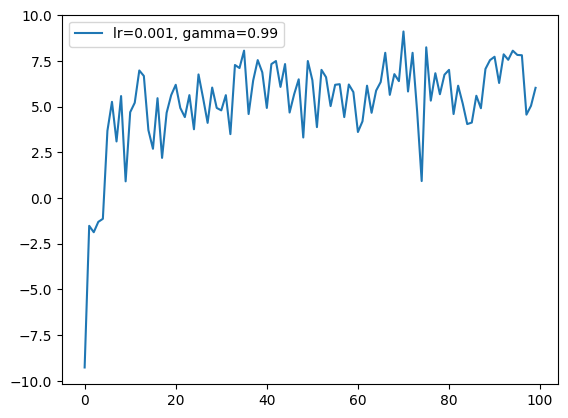

In [30]:
# plot the results
import matplotlib.pyplot as plt

for lr in learning_rates:
    for gamma in gammas:
        plt.plot(results_2[lr][gamma], label=f"lr={lr}, gamma={gamma}")
plt.legend()
plt.show()

Perform Tests on 50% LLM

In [31]:
from natural20.generic_controller import GenericController
from natural20.gym.dndenv_controller import DndenvController

eval_env = make_env(game_setup_path)

def mix_controller(session):
    # 60% of the time use the generic controller, 50% LLM
    if (random.random() < 0.6):
        return GenericController(session)
    else:
        return DndenvController(session, agent)

env = make_env(game_setup_path, custom_agent=mix_controller)

In [32]:
seed = 1337
# Create a grid of learning rates and gammas
learning_rates = [0.001]
gammas = [0.99]

results_3 = {}
for lr in learning_rates:
  results_3[lr] = {}
  for gamma in gammas:
    seed = seed + 1
    reward_per_episode = train(env, gamma, lr, max_steps=MAX_STEPS, seed=seed, \
                               eval_env=eval_env, trajectory_policy='e-greedy', label="llm_adversary_0.5")
    results_3[lr][gamma] = reward_per_episode

training with gamma 0.99 and learning rate 0.001


  0%|          | 0/1000 [00:00<?, ?it/s]

0: avg rewards -2.3833333333333333 std: 7.456838770178986 best avg -10@0 epsilon 1.0
Buffer size: 8
Memory usage: 165248 bytes
best: -2.3833333333333333
10: avg rewards -6.583333333333332 std: 6.556379420923649 best avg -2.3833333333333333@0 epsilon 0.9911299749851548
Buffer size: 88
Memory usage: 1879808 bytes
list index out of range
unusual response: 3: end my turn
20: avg rewards 3.7833333333333337 std: 7.830602360823421 best avg -2.3833333333333333@0 epsilon 0.9813675686203779
Buffer size: 168
Memory usage: 3377088 bytes
best: 3.7833333333333337
list index out of range
unusual response: 3: ?
list index out of range
unusual response: 3: Get up from prone
list index out of range
unusual response: 3: end my turn
30: avg rewards 7.033333333333332 std: 6.080844239632083 best avg 3.7833333333333337@20 epsilon 0.9717022998219388
Buffer size: 248
Memory usage: 5241664 bytes
best: 7.033333333333332
40: avg rewards 3.483333333333334 std: 7.526693238807537 best avg 7.033333333333332@30 epsilo

In [33]:
for item in results_3:
  for gamma in results_3[item]:
    print(f"lr: {item} gamma: {gamma} rewards: {results_3[item][gamma]}")

lr: 0.001 gamma: 0.99 rewards: [-2.3833333333333333, -6.583333333333332, 3.7833333333333337, 7.033333333333332, 3.483333333333334, 6.266666666666667, 3.3833333333333333, 6.4, 4.883333333333333, 4.383333333333333, 5.166666666666668, 6.2, 1.2833333333333334, 1.8, 5.7666666666666675, 6.0, 3.7500000000000004, 3.8, 2.6166666666666667, 0.13333333333333336, 1.4833333333333334, 5.033333333333333, 3.5333333333333337, 2.1333333333333337, 4.95, -0.16666666666666657, 6.0, 4.916666666666667, 5.033333333333333, 6.416666666666668, 2.166666666666667, 4.25, 3.583333333333334, 5.616666666666666, 1.8833333333333337, 6.933333333333333, 1.7000000000000002, 5.333333333333332, 5.066666666666666, 4.85, 4.95, 4.666666666666667, 3.966666666666667, 5.316666666666667, 7.933333333333334, 6.866666666666666, 4.35, 7.3, 3.6333333333333337, 6.983333333333333, 4.65, 8.3, 5.816666666666666, 3.483333333333333, 5.183333333333334, 6.633333333333333, 7.1, 6.45, 3.083333333333334, 8.15, 7.75, 4.166666666666666, 6.8, 5.850000

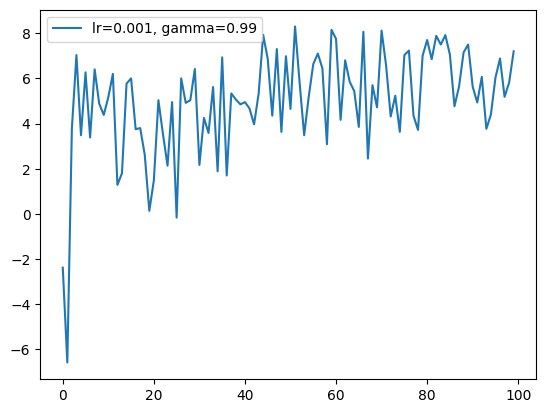

In [35]:
# plot the results
import matplotlib.pyplot as plt

for lr in learning_rates:
    for gamma in gammas:
        plt.plot(results_3[lr][gamma], label=f"lr={lr}, gamma={gamma}")
plt.legend()
plt.show()

Configure prompter for mistral

In [15]:
VARIANT = 'mistralai/Mistral-7B-Instruct-v0.3'
URL = "http://202.92.159.242:8000/v1"
prompt_mistral = GPT4Interfacer(debug=False, tools=False, base_url=URL, api_key="token1234", variant=VARIANT, explain=False)


In [16]:
class CustomAgent:
    def __init__(self, llm_interface):
        self.llm_interface = llm_interface

    def step(self, observation, info):
        return self.llm_interface.select_action_for_state(observation, info)

    def __str__(self) -> str:
        return "Custom LLM Agent"

agent_mistral = CustomAgent(prompt_mistral)

In [26]:
from natural20.generic_controller import GenericController
from natural20.gym.dndenv_controller import DndenvController
from llm_interface import GPT4Interfacer

eval_env = make_env(game_setup_path)

def mix_controller_mistral(session, mix=0.8, **kwargs):
    # 80% of the time use the generic controller, 20% LLM
    if (random.random() < mix):
        return GenericController(session)
    else:
        return DndenvController(session, agent_mistral)

env = make_env(game_setup_path, custom_agent=mix_controller_mistral)

In [27]:
seed = 1337
# Create a grid of learning rates and gammas
learning_rates = [0.001]
gammas = [0.99]

results_4 = {}
for lr in learning_rates:
  results_4[lr] = {}
  for gamma in gammas:
    seed = seed + 1
    reward_per_episode = train(env, gamma, lr, max_steps=MAX_STEPS, seed=seed, \
                               eval_env=eval_env, trajectory_policy='e-greedy', label="llm_adversary_mistral")
    results_4[lr][gamma] = reward_per_episode

training with gamma 0.99 and learning rate 0.001


  0%|          | 0/1000 [00:00<?, ?it/s]

0: avg rewards -3.5 std: 7.3645170317619 best avg -10@0 epsilon 1.0
Buffer size: 8
Memory usage: 140160 bytes
best: -3.5
list index out of range
unusual response:  3: Stand up (Reaction)
4: Move 5ft towards enemy (Movement)
5: Attack enemy with melee weapon (Action)
list index out of range
unusual response:  2: Action: Move 5ft (to get out of prone condition)
Bonus Action: Stand Up
Reaction: None (since there's no provocation from the enemy)

Then:
1: Attack Enemy with melee weapon (since I'm in the enemy's line of sight and within reach)
list index out of range
unusual response:  2: Stand up (Dash action to stand up from prone state)
3: Bonus Action: Ready an Action (Ready an action to take advantage of the enemy's dodging state)
4: Reaction: Opportunity Attack (Since the enemy moves out of my reach)

After the enemy moves, use the ready action to attack with a melee weapon (attack action).

So the answer is:
2: Stand up
3: Bonus Action: Ready an Action
4: Reaction: Opportunity Attack

Perform some tests on the trained agent. Show a combat log from a fight against the rules based AI. Define a policy based on the Model.

In [ ]:
import os

MAX_STEPS = 500
NUM_EPISODES = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ModelPolicy:
    def __init__(self, weights_file = 'model_best_dnd_egreedy.pt'):
        self.model = QNetwork(device=device)
        self.model.to(device)
        if not os.path.exists(weights_file):
            raise FileNotFoundError(f"Model file {weights_file} not found. Please run dnd_dqn.ipynb notebook to train an agent.")
        self.model.load_state_dict(torch.load(weights_file))

    def action(self, state, info):
        available_moves = info["available_moves"]
        values = torch.stack([self.model(state, move) for move in available_moves])
        for index, v in enumerate(values):
            print(f"{index}: {available_moves[index]} {v.item()}")

        chosen_index = torch.argmax(values).item()
        return available_moves[chosen_index]


In [ ]:

env = make_env(game_setup_path)

print("=========================================")
print("Battle between an RL agent vs a Rules based AI")
print("=========================================")
win_count = 0
loss_count = 0
for i in range(NUM_EPISODES):
    observation, info = env.reset()
    model = ModelPolicy()
    action = action = model.action(observation, info)

    print(f"selected action: {action}")
    terminal = False
    episode = 0

    while not terminal and episode < MAX_STEPS:
        episode += 1
        observation, reward, terminal, truncated, info = env.step(action)
        print(env.render())
        if not terminal and not truncated:
            episode_name_with_padding = str(episode).zfill(3)

            # display entity healths
            print(f"Turn {info['current_index']}\n")
            print(f"Reward: {reward}\n")
            print(f"health hero: {observation['health_pct']}\n")
            print(f"health enemy: {observation['health_enemy']}\n")
            print(env.render())
            
            action = model.action(observation, info)
            print(f"agent selected action: {action}")

        if terminal or truncated:
            print(f"Reward: {reward}")
            if reward > 0:
                win_count += 1
            else:
                loss_count += 1
            break
        
print(f"Win count: {win_count} Loss count: {loss_count} Win rate: {win_count/(win_count+loss_count)}")

Run a tournament on the various types of agents and show ranking:

1. Simple AI vs LLM

2. Simple AI vs ai-trained model

3. LLM vs AI-trained model

4. AI-trained vs LLM-trained model